## 解析するスピン画像ファイルの選択

In [4]:
#directory_name = "skate_2017fs_spi"
#directory_name = "skate_2012_spi3"
directory_name = "skate_2014gpf"


In [8]:
np.version.full_version

'1.13.3'

In [10]:
cv2.__version__

'3.3.1'

In [9]:
import sys

print(sys.version)

3.5.4 (v3.5.4:3f56838, Aug  8 2017, 02:17:05) [MSC v.1900 64 bit (AMD64)]


## スピン画像ファイル群から座標とファイル名の取り出し

In [5]:
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt

import copy
from scipy.stats import zscore

import os
import re

h = 0
w = 1

def json_files_open(directory_name):
    
    # 画像からサイズを取り出す
    def get_image_size(img_name):
        img_ = cv2.imread(img_name)
        return np.delete(np.array(img_.shape), 2)

    # targetの決定とkptの取り出し(reshape済)
    def take_out_kpt(data, img_size):

        #print("人数:"+str(len(data["people"])))

        x = [] 
        y = []

        x_mean = []
        y_mean = []
        kpt_num = []

        for people in data['people']:
            kpt = np.array(people['pose_keypoints']).reshape((18, 3))

            #x,yに分ける
            for i in range(18):
                if (kpt[i,2] != 0): 
                    x = np.append(x,kpt[i,0])
                    y = np.append(y,kpt[i,1])
            
            #keypointの数、x,y座標の平均値（中央を原点とした、）
            kpt_num = np.append(kpt_num, len(x))
            x_mean = np.append(x_mean, np.mean(x - img_size[w] / 2))
            y_mean = np.append(y_mean, np.mean(y - img_size[h] / 2))

        #人の情報(x,y座標)を集約
        people_info = np.append(x_mean,y_mean).reshape(2,-1)


        #絶対値の最小値をとる要素番号を導出
        xy_argmin = np.argmin(np.absolute(people_info),axis=1)
        #print("xy_argmin + kpt_num_argmax:" + str(np.append(xy_argmin, np.argmax(kpt_num))))

        #keypointの数、x,y座標の平均値を比較し、最も多い人の要素番号を導出
        target_index = np.argmax(np.bincount(np.append(xy_argmin, np.argmax(kpt_num))))
        #print("bincount:" + str(np.bincount(np.append(xy_argmin, np.argmax(kpt_num))))) #np.append()の出現回数を出力
        #print("target_index:" + str(target_index))

        #targetの情報取り出し
        people_data = data["people"]
        target = people_data[target_index]
        target_kpt = np.array(target["pose_keypoints"]).reshape(18,3)

        return target_kpt

    
    # 標準化
    def conv_kpt_zscore(kpt):
        x = [] 
        y = []

        for i in range(18):
            if kpt[i,2] != 0:
                x = np.append(x,kpt[i,0])
                y = np.append(y,kpt[i,1])

        x_zscore = zscore(x)
        y_zscore = zscore(y)

        j = 0
        for i in range(18):
            if(kpt[i,2]) != 0:
                kpt[i,0] = copy.copy(x_zscore[j])
                kpt[i,1] = copy.copy(y_zscore[j])
                j += 1

    _json = re.compile("json") # ファイルのマッチに使うための正規表現
    _png = re.compile("png")

    all_frame_kpt = []       # 全てのkeypointの座標と信頼度を格納する配列の宣言
    success_file_names = []  # 全てのjsonファイルの名前を格納する配列の宣言

    directory = os.listdir(directory_name)

    # ディレクトリの移動
    os.chdir(directory_name)

    # 画像サイズの取り出し
    for file in directory:
        if _png.search(file):
            try:
                img_size = get_image_size(file)
                print(file+"\t:get_image_size success")
                break
            except:
                print(file+"\t:get_image_size failed")

    # jsonファイル読み込みとデータ取出し
    n = 0
    m = 0
    for file in directory:
        if _json.search(file):
            try:
                with open(file, 'r') as f:
                    data = json.load(f)

                #ここでデータ取出し、標準化する
                kpt = take_out_kpt(data, img_size)
                conv_kpt_zscore(kpt)
                all_frame_kpt = np.append(all_frame_kpt,kpt)
                success_file_names = np.append(success_file_names, file)
                
                print(file+"\t:success")
                n += 1

            except:
                print(file+"\t:failed")
                m += 1

    print("successファイル数: "+ str(n))
    print("failedファイル数: "+ str(m))
    os.chdir("../")
    
    return all_frame_kpt, success_file_names


In [3]:
# jsonファイルが抽出できているか確認
akr, file_names = json_files_open(directory_name)

image0016_rendered.png	:get_image_size success
image0016_keypoints.json	:success
image0017_keypoints.json	:success
image0018_keypoints.json	:success
image0019_keypoints.json	:success
image0020_keypoints.json	:success
image0021_keypoints.json	:success
image0022_keypoints.json	:success
image0023_keypoints.json	:success
image0024_keypoints.json	:success
image0025_keypoints.json	:success
image0026_keypoints.json	:success
image0027_keypoints.json	:success
image0028_keypoints.json	:success
image0029_keypoints.json	:success
image0030_keypoints.json	:success
image0031_keypoints.json	:success
image0032_keypoints.json	:success
image0033_keypoints.json	:success
image0034_keypoints.json	:success
image0035_keypoints.json	:success
image0036_keypoints.json	:success
image0037_keypoints.json	:success
image0038_keypoints.json	:success
image0039_keypoints.json	:success
image0040_keypoints.json	:success
image0041_keypoints.json	:success
image0042_keypoints.json	:success
image0043_keypoints.json	:success
i

## グラフ描画(足のx座標の変化)

In [4]:
# pose_keypointにおける足先10番目(RightAnkle)と13番目(LeftAnkle)のx座標の配列の初期化

# {ファイル数,18(体部分),3(x座標、y座標,信頼度)}になるよう整形
akr = akr.reshape(-1,18,3)

kp_x = []
for i in range(len(akr)):
    if akr[i, 10, 0] != 0 and akr[i, 13, 0] != 0:    #両方とも0が出力されている場合は除く
        
        if abs(akr[i, 10, 0]) > abs(akr[i, 13, 0]):  #足部分x座標の絶対値が大きい方
            kp_x = np.append(kp_x, akr[i, 10, 0])
        elif abs(akr[i, 13, 0]) > abs(akr[i, 10, 0]):#足部分x座標の絶対値が大きい方
            kp_x = np.append(kp_x, akr[i, 13, 0])
        else:                                        
            continue

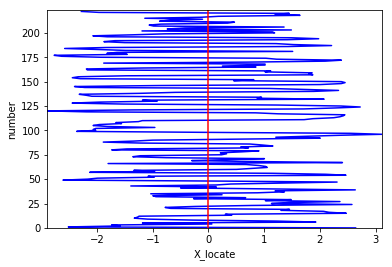

In [5]:
# 実際の足の動きに合わせるためx軸に足のx座標、y軸に画像枚数を設定

x = kp_x
y = np.arange(0, len(kp_x), 1)

plt.xlim(min(kp_x), max(kp_x)) # x軸の範囲を限定
plt.ylim(0, len(kp_x))         # y軸の範囲を限定
plt.plot(x, y, 'b')            # グラフ描画
plt.plot([0,0], [0, len(kp_x)], 'r')   #中央軸

plt.xlabel("X_locate")     #標準化された足のx座標の位置  
plt.ylabel("number")       #画像何枚目か

plt.show()

## スピンの回転数

In [6]:
n = 0 #回転数の初期化
i = 1
for i in range(len(akr)):
    
    #x座標の前後で両方とも正か両方とも負の場合　すなわち、中央軸と重なる点がない場合
    if ((akr[i - 1, 10, 0]) > 0 and (akr[i, 10, 0]) > 0) or ((akr[i - 1, 10, 0]) < 0 and (akr[i, 10, 0]) < 0):
        continue
    
    #x座標の前後で片方が正、もう片方が負の場合　すなわち、中央軸と重なる点がある場合
    else:
        n +=1

        
print("スピンの回転数:" + str(n/2))  #中央軸と重なった回数/2 = 回転数

スピンの回転数:103.0


## グラフ描画(足のy座標の変化)

In [7]:
#pose_keypointにおける足先10番目(RightAnkle)と13番目(LeftAnkle)のy座標の配列の初期化

kp_y = []
for i in range(len(akr)):
    if akr[i, 10, 1] != 0 and akr[i, 13, 1] != 0: #0が出力されている場合は除く
        if akr[i, 10, 1] < akr[i, 13, 1]:  #足部分y座標の小さい方 = 足が上がっている方
            kp_y = np.append(kp_y, akr[i, 10, 1])
        elif akr[i, 13, 1] < akr[i, 10, 1]:#足部分y座標の小さい方 = 足が上がっている方
            kp_y = np.append(kp_y, akr[i, 13, 1])
        else:
            continue

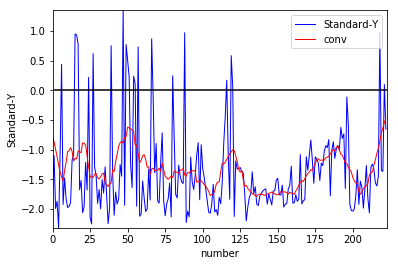

In [8]:
x = np.arange(0, len(kp_y), 1) # x軸(時系列)を設定
y1 = -kp_y                     # y軸(足のy座標)を設定 画像の動きと合わせるため、yの値を反転
v = np.ones(15)/15.0           # 移動平均をとるための配列vを設定。今回は前後10個の値を用いて平均をとる。
y2 = np.convolve(y1, v, mode='same')

plt.xlim(0, len(y1))        
plt.ylim(min(y1), max(y1))
plt.plot(x, y1,'b', linewidth=1, label = "Standard-Y")
plt.plot(x, y2,'r', linewidth=1, label = "conv")
plt.plot([0, len(kp_y)], [0, 0], 'k')   # 移動平均の中央軸
plt.legend()
plt.xlabel("number")      # 画像何枚目か
plt.ylabel("Standard-Y")  # 標準化されたy座標
plt.show()

## グラフ描画(首のy座標の変化)

In [9]:
#pose_keypointにおける1番目(Neck)のy座標の配列の初期化

kp_y = []
for i in range(len(akr)):
    if akr[i, 1, 1] != 0: #0が出力されている場合は除く
            kp_y = np.append(kp_y, akr[i, 1, 1])
    else:
        continue

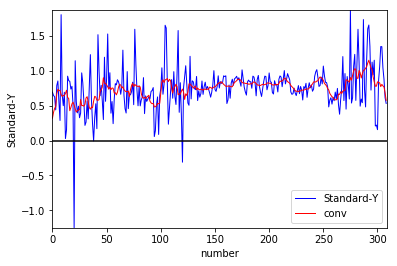

In [10]:
x = np.arange(0, len(kp_y), 1)  # x軸(時系列)を設定
y1 = -kp_y                      # y軸(足のy座標)を設定 画像の動き合わせるため、yの値を反転
v = np.ones(10)/10.0            # 移動平均をとるための配列vを設定
y2 = np.convolve(y1, v, mode='same')

plt.xlim(0, len(y1))        
plt.ylim(min(y1), max(y1))
plt.plot(x, y1,'b', linewidth=1, label = "Standard-Y")
plt.plot(x, y2,'r', linewidth=1, label = "conv")
plt.plot([0, len(kp_y)], [0, 0], 'k')   # 中央軸
plt.legend()
plt.xlabel("number")        # 画像何枚目か
plt.ylabel("Standard-Y")    # 標準化されたy座標
plt.show()

### グラフ描画(首と足の差など)

In [11]:
#pose_keypointにおける1番目(Neck)と10番目(RightAnkle)と13番目(LeftAnkle)のy座標の配列の初期化
kp_x_n = [] # 首のx座標を入れる配列
kp_y_n = [] # 首のy座標を入れる配列
kp_y = []   # 足のy座標を入れる配列

kp_fnames = []

for i in range(len(akr)):
    if (akr[i, 10, 1] != 0 and akr[i, 13, 1] != 0 and akr[i, 1, 1] != 0): #0が出力されている場合は除く
        kp_y_n = np.append(kp_y_n, akr[i, 1, 1])
        kp_x_n = np.append(kp_x_n, akr[i, 1, 0])
        
        kp_fnames = np.append(kp_fnames, file_names[i]) #スピンの種類とファイル名を対応させるための配列
            
        if (akr[i, 10, 1] < akr[i, 13, 1]):  #y座標の小さい方
            kp_y = np.append(kp_y, akr[i, 10, 1])
            
        elif (akr[i, 13, 1] < akr[i, 10, 1]):#y座標の小さい方
            kp_y = np.append(kp_y, akr[i, 13, 1])
            
        else:
            continue

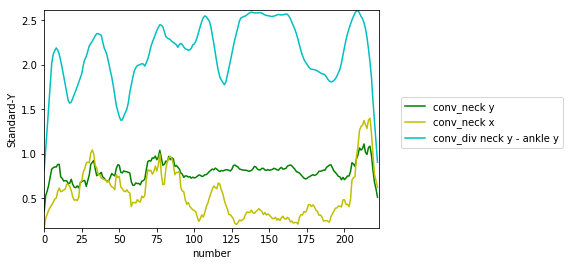

In [12]:
x = np.arange(0, len(kp_y), 1) # x軸(時系列)を設定
y = kp_y                       # y軸(足のy座標)
y2 = -kp_y_n                   # y軸(首のy座標) 画像の動きと合わせるため反転
y3 = abs(kp_x_n)               # y軸(首のx座標の絶対値)

v = np.ones(10)/10.0                  # 移動平均をとるための配列vを設定
y = np.convolve(y, v, mode='same')    # 足のy座標の移動平均

y2 = np.convolve(y2, v, mode='same')  # 首のy座標の移動平均

y3 = np.convolve(y3, v, mode='same')  # 首のx座標の移動平均

y4 = y2 + y
y4 = np.convolve(y4, v, mode='same')  # 足と首のy座標の差の平均

minimum = (min(y2), min(y3), min(y4)) # 各グラフの最小値を格納
maximum = (max(y2), max(y3), max(y4)) # 各グラフの最大値を格納
plt.xlim(0, len(kp_y))        
plt.ylim(min(minimum), max(maximum))  # 複数のグラフの中で最小値と最大値をグラフの端に設定

plt.plot(x, y2, 'g', label = "conv_neck y") 
plt.plot(x, y3, 'y', label = "conv_neck x")
plt.plot(x, y4, 'c', label = "conv_div neck y - ankle y")
plt.plot([0, len(kp_y)], [0,0], 'r', lw = 0.5)  

plt.xlabel("number")        # 画像何枚目か
plt.ylabel("Standard-Y")    # 標準化されたy座標
plt.legend(loc='upper right', bbox_to_anchor=(1.05, 0.5, 0.5, .100), borderaxespad=0.,) #凡例をグラフ外に表示

plt.show()

### 膝や尻、首の座標を扱う

In [13]:
#スピン軸足の膝(Knee)、尻(Hip)、軸足じゃない方の足の膝(Knee)、尻(Hip)の初期化
#膝は9,12番目、尻は8,11番目のkey-point

#{ファイル数,18(体部分),3(x座標、y座標,信頼度)}になるよう整形
akr = akr.reshape(-1,18,3)

kp_x_a = []
kp_y_a = []

kp_x_n = []
kp_y_n = []

kp_y_hip = []
kp_y_knee = []

kp_y_hip_a = []
kp_y_knee_a = []


for i in range(len(akr)):
    if akr[i, 10, 0] != 0 and akr[i, 13, 0] != 0 and akr[i, 1, 0] != 0: #両方とも0が出力されている場合は除く
        kp_x_n = np.append(kp_x_n, akr[i, 1, 0])
        kp_y_n = np.append(kp_y_n, akr[i, 1, 1])
        
        if abs(akr[i, 10, 0]) > abs(akr[i, 13, 0]):  #足部分x座標の絶対値の大きい方
            
            #軸足じゃない方の尻、膝のy座標
            kp_y_hip = np.append(kp_y_hip, akr[i, 8, 1])
            kp_y_knee = np.append(kp_y_knee, akr[i, 9, 1])
            
            #軸足の尻、膝のy座標
            kp_y_hip_a = np.append(kp_y_hip_a, akr[i, 11, 1])
            kp_y_knee_a = np.append(kp_y_knee_a, akr[i, 12, 1])
            
            kp_x_a = np.append(kp_x_a, akr[i, 13, 0])
            
        elif abs(akr[i, 13, 0]) > abs(akr[i, 10, 0]): #足部分x座標の絶対値の大きい方
            
            #軸足じゃない方の尻、膝のy座標
            kp_y_hip = np.append(kp_y_hip, akr[i, 11, 1])
            kp_y_knee = np.append(kp_y_knee, akr[i, 12, 1])
            
            #軸足の尻、膝のy座標
            kp_y_hip_a = np.append(kp_y_hip_a, akr[i, 8, 1])
            kp_y_knee_a = np.append(kp_y_knee_a, akr[i, 9, 1])

            kp_x_a = np.append(kp_x_a, akr[i, 10, 0])

            
        else:                                        
            continue

In [14]:
# 差をグラフにするため初期化
div_hip_knee = -(kp_y_hip - kp_y_knee)       # 軸足じゃない方の尻のy座標と膝のy座標の差
div_hip_knee_a = -(kp_y_hip_a - kp_y_knee_a) # 軸足の尻のy座標と膝のy座標の差
div_neck_hip = -(kp_y_n - kp_y_hip)          # 首のy座標と尻のy座標の差

### グラフ描画(軸足の尻と膝のy座標の差)

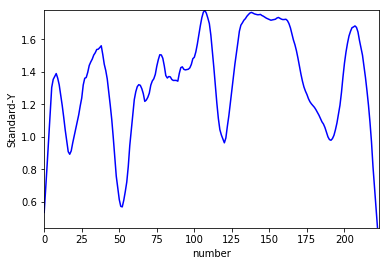

In [15]:
x = np.arange(0, len(y), 1) # x軸(時系列)を設定
v = np.ones(10)/10.0        # 移動平均をとるための配列vを設定

y2 = div_hip_knee_a         # y軸()を設定
y2 = np.convolve(y, v, mode='same') # 軸足じゃない方の尻と膝のy座標の差の移動平均

plt.xlim(0, len(y2))        
plt.ylim(min(y2), max(y2)) 
plt.plot(x, y2, 'b')                   
plt.plot([0, len(y2)],[0,0], 'r')   

plt.xlabel("number")      #画像何枚目か
plt.ylabel("Standard-Y")  #標準化されたy座標
plt.show()

### グラフ描画(複数のグラフ)

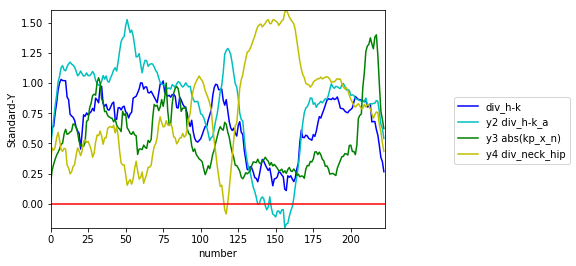

In [20]:
x = np.arange(0, len(y), 1) # x軸(時系列)を設定
v = np.ones(10)/10.0        # 移動平均をとるための配列vを設定

y = div_hip_knee            # 軸足じゃない方の尻のy座標と膝のy座標の差
y = np.convolve(y, v, mode='same')

y2 = div_hip_knee_a         # 軸足の尻のy座標と膝のy座標の差
y2 = np.convolve(y2, v, mode='same')

y3 = abs(kp_x_n)            # 首のx座標の絶対値
y3 = np.convolve(y3, v, mode='same')

y4 = div_neck_hip           # 首のy座標と尻のy座標の差
y4 = np.convolve(y4, v, mode='same')

minimum = (min(y), min(y2), min(y3), min(y4))
maximum = (max(y), max(y2), max(y3), max(y4))
plt.xlim(0, len(y))        
plt.ylim(min(minimum), max(maximum)) 
plt.plot(x, y, 'b' , label = "div_h-k")                   
plt.plot(x, y2, 'c', label = "y2 div_h-k_a")                  
plt.plot(x, y3, 'g', label = "y3 abs(kp_x_n)")                  
plt.plot(x, y4, 'y', label = "y4 div_neck_hip")                  
plt.plot([0, len(y)],[0,0], 'r')   

plt.xlabel("number")        # 画像何枚目か
plt.ylabel("Standard-Y")    # 標準化されたy座標
plt.legend(loc='upper right', bbox_to_anchor=(1.05, 0.5, 0.5, .100), borderaxespad=0.,) #凡例をグラフ外に表示
plt.show()

## スピン判定

In [23]:
for i in range(len(y)):
    
    # 軸足の尻のy座標と膝のy座標の差が0.2より小さいと
    if y2[i] < 0.2:
        print("%d\t%s\tシットスピン"%(i,kp_fnames[i]))
        
    # 首のx座標の絶対値が首全てのx座標の中央値より大きく、首と尻のy座標の差が全てのy座標の中央値より小さいと
    elif y3[i] > np.median(y3) and y4[i] < np.median(y4) : 
        print("%d\t%s\tキャメルスピン"%(i,kp_fnames[i]))
        
    # 上記以外
    else:
        print("%d\t%s\tアップライトスピン"%(i,kp_fnames[i]))
       

0	image0016_keypoints.json	アップライトスピン
1	image0017_keypoints.json	アップライトスピン
2	image0020_keypoints.json	アップライトスピン
3	image0021_keypoints.json	アップライトスピン
4	image0023_keypoints.json	アップライトスピン
5	image0025_keypoints.json	アップライトスピン
6	image0027_keypoints.json	アップライトスピン
7	image0029_keypoints.json	キャメルスピン
8	image0032_keypoints.json	キャメルスピン
9	image0033_keypoints.json	キャメルスピン
10	image0034_keypoints.json	キャメルスピン
11	image0035_keypoints.json	キャメルスピン
12	image0036_keypoints.json	キャメルスピン
13	image0039_keypoints.json	キャメルスピン
14	image0040_keypoints.json	キャメルスピン
15	image0042_keypoints.json	キャメルスピン
16	image0044_keypoints.json	キャメルスピン
17	image0045_keypoints.json	キャメルスピン
18	image0046_keypoints.json	キャメルスピン
19	image0047_keypoints.json	キャメルスピン
20	image0048_keypoints.json	アップライトスピン
21	image0054_keypoints.json	キャメルスピン
22	image0055_keypoints.json	アップライトスピン
23	image0056_keypoints.json	キャメルスピン
24	image0057_keypoints.json	キャメルスピン
25	image0059_keypoints.json	キャメルスピン
26	image0060_keypoints.json	キャメルスピン
27	image0061_keypoin